# 🛍️ Mall Customers – Cluster Analysis (K-Means + Hierárquico)
---
Notebook completo com análise de cluster usando **K-Means**, **Dendrograma**, **Elbow Method** e **ANOVA**.

# 🗂️ Fonte da Base de Dados
A base utilizada é o Mall Customers Dataset, disponível publicamente no Kaggle:
🔗 https://www.kaggle.com/datasets/shwetabh123/mall-customers

## 📦 0. Importação das Bibliotecas

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import zscore
import pingouin as pg


## 📂 1. Leitura da Base & EDA Inicial

In [8]:
mall = pd.read_csv('Mall_Customers.csv')
print(mall.info())

# 1.1 Média de Renda Anual por Gênero
mall.groupby('Genre')['Annual Income (k$)'].mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


Genre
Female    59.250000
Male      62.227273
Name: Annual Income (k$), dtype: float64

## 🎛️ 2. Padronização das Variáveis Numéricas

In [9]:
mallnumeric = mall.drop(columns=['CustomerID', 'Genre'])
mallpad = mallnumeric.apply(zscore, ddof=1)
testeanova = mallpad.copy() # Duplicando para ANOVA futura

## 📉 2.1 Matriz de Correlação + Heatmap 

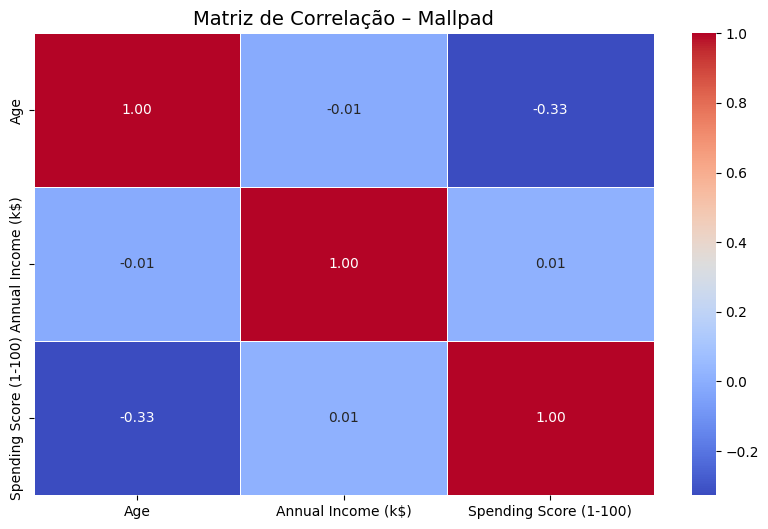

In [15]:
# Matriz de correlação
corr = mallpad.corr()

# Plot do heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    linewidths=0.5,
    fmt='.2f'
)
plt.title("Matriz de Correlação – Mallpad", fontsize=14)
plt.show()

## 🌳 3. Cluster Hierárquico – Dendrograma

O maior salto está entre: 4.8 e 6.0


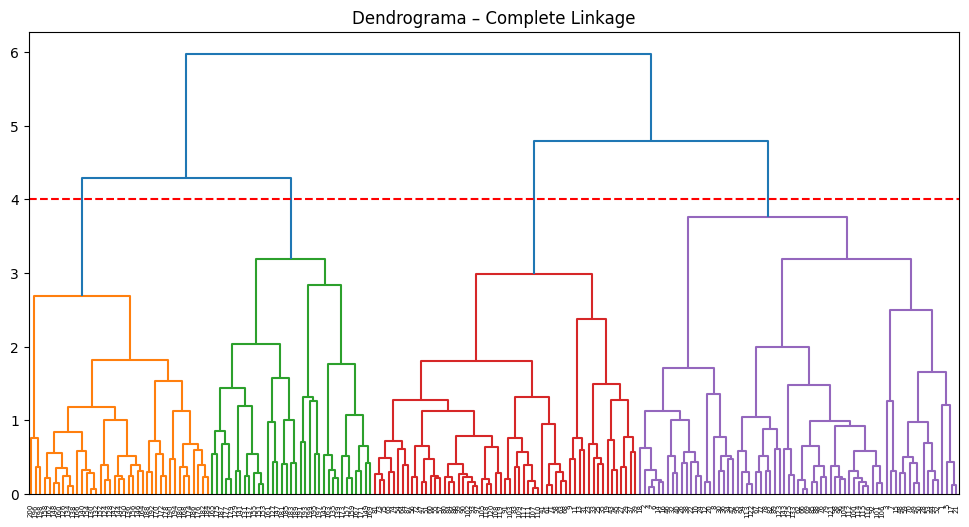

In [10]:
mall_compl = sch.linkage(mallpad, metric='euclidean', method='complete')

# maior salto
dists = mall_compl[:, 2]
saltos = np.diff(dists)
i = np.argmax(saltos)
print(f"O maior salto está entre: {dists[i]:.2} e {dists[i+1]:.2}")

#⚠️ Vamos considerar 4 clusters, considerando as evidências anteriores!
# plot
plt.figure(figsize=(12, 6))
sch.dendrogram(mall_compl, color_threshold=4, labels=list(mall['CustomerID']))
plt.axhline(y=4, color='red', linestyle='--')
plt.title("Dendrograma – Complete Linkage")
plt.show()

## 📉 4. Escolha do Número Ideal de Clusters – Elbow Method

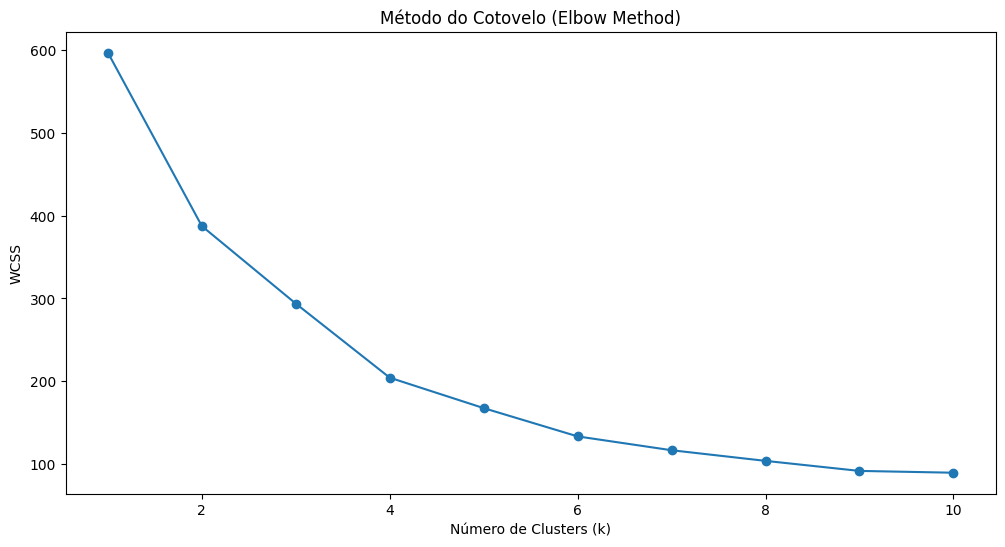

In [11]:
wcss = []
ks = range(1, 11)

for k in ks:
    kmeans = KMeans(n_clusters=k, init='random', random_state=42)
    kmeans.fit(mallpad)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(ks, wcss, marker='o')
plt.xlabel("Número de Clusters (k)")
plt.ylabel("WCSS")
plt.title("Método do Cotovelo (Elbow Method)")
plt.show()

## 📉 4.1 Escolha do Número Ideal de Clusters  – Silhouette Method – Elbow Method

In [12]:
for k in range(2, 10):
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(mallpad)
    print(f"k = {k} | Silhouette Score = {silhouette_score(mallpad, labels):.4f}")

k = 2 | Silhouette Score = 0.3355
k = 3 | Silhouette Score = 0.3579
k = 4 | Silhouette Score = 0.4040
k = 5 | Silhouette Score = 0.4085
k = 6 | Silhouette Score = 0.4311
k = 7 | Silhouette Score = 0.4101
k = 8 | Silhouette Score = 0.3674
k = 9 | Silhouette Score = 0.3744


## 🎯 5. Modelo Final – KMeans com k = 4

In [ ]:
cluster_final = KMeans(n_clusters=4, init='random', random_state=42).fit(mallpad)
cluster_KMeans = cluster_final.labels_

mall['Cluster_KMeans'] = cluster_KMeans
testeanova['Cluster_KMeans'] = cluster_KMeans
mall.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster_KMeans
0,1,Male,19,15,39,3
1,2,Male,21,15,81,3
2,3,Female,20,16,6,3
3,4,Female,23,16,77,3
4,5,Female,31,17,40,3


## 📊 6. ANOVA – Comparação Estatística Entre os Clusters

In [ ]:
print("\nANOVA – Age")
print(pg.anova(dv='Age', between='Cluster_KMeans', data=testeanova, detailed=True).T)

print("\nANOVA – Annual Income (k$)")
print(pg.anova(dv='Annual Income (k$)', between='Cluster_KMeans', data=testeanova, detailed=True).T)

print("\nANOVA – Spending Score (1-100)")
print(pg.anova(dv='Spending Score (1-100)', between='Cluster_KMeans', data=testeanova, detailed=True).T)


ANOVA – Age
                     0          1
Source  Cluster_KMeans     Within
SS          136.210895  62.789105
DF                   3        196
MS           45.403632   0.320353
F           141.730191        NaN
p-unc              0.0        NaN
np2           0.684477        NaN

ANOVA – Annual Income (k$)
                     0          1
Source  Cluster_KMeans     Within
SS          125.381666  73.618334
DF                   3        196
MS           41.793889   0.375604
F           111.271224        NaN
p-unc              0.0        NaN
np2           0.630059        NaN

ANOVA – Spending Score (1-100)
                     0          1
Source  Cluster_KMeans     Within
SS          131.208417  67.791583
DF                   3        196
MS           43.736139   0.345875
F           126.450555        NaN
p-unc              0.0        NaN
np2           0.659339        NaN
